In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from panel import state

In [2]:
# Initialising graph options for plotting
plt.style.use("ggplot")
plt.rcParams.update({'font.size': 20})

# Option to make the plotting to be interactive
pd.options.plotting.backend = "plotly"

## Getting data from CSV file - 2020 USA by state

* Number of confirmed cases
* Number of Deaths
* Last date of the report: 07/09/2020.

In [3]:
# Creating the DataFrame from the CSV file - 2020 data per US state (confirmed cases and deaths)
state_data_df = pd.read_csv("./Resources/usa_county_wise.csv")
state_data_df

print (f"The latest report containing in this CSV file is {state_data_df['Date'].max()}.")

The latest report containing in this CSV file is 7/9/20.


In [4]:
# Filtering the data based on the last date
state_data_df = state_data_df.loc[state_data_df["Date"] == state_data_df["Date"].max(),:]

In [5]:
# Drop unwanted columns
state_clean_df = state_data_df.drop(["UID", "iso2", "iso3", "code3", "FIPS", "Admin2", "Country_Region", "Lat", "Long_", "Combined_Key", "Date"], axis = 1)

# states list for isin function
states = ['Alabama', 'Alaska', 'Arizona',
       'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware',
        'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota',
       'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
       'West Virginia', 'Wisconsin', 'Wyoming']

# Removing unwanted data
state_clean_df = state_clean_df[state_clean_df["Province_State"].isin(states)]

# Used to test states list filter works
# state_clean_df["Province_State"].unique()

#print the dataframe
state_clean_df

,Province_State,Confirmed,Deaths
564542,Alabama,653,13
564543,Alabama,1114,10
564544,Alabama,367,2
564545,Alabama,208,1
564546,Alabama,273,1
...,...,...,...
567795,Utah,243,0
567796,Utah,47,0
567797,Utah,1881,15
567798,Utah,63,0


In [6]:
# group the statistics by the sum of cases and deaths by state
state_clean2_df = state_clean_df.groupby(by = ["Province_State"]).sum()
state_clean2_df

,Confirmed,Deaths
Province_State,,
Alabama,49174,1043
Alaska,1268,46
Arizona,112671,2063
Arkansas,26052,311
California,302484,6860
Colorado,35507,1706
Connecticut,47209,4348
Delaware,12531,508
Florida,232718,4018


## Getting data from Census API

* Check the population for each state via Census API call
* Calculate Deaths per capita
* Calculate Cases per capita
* Identify the correlatoin between Confirmed Cases and Deaths

In [7]:
# Importing dependencies
import requests
from census import Census

# Census & Gmaps API Keys
from api_keys import (census_api_key)
c = Census(census_api_key, year=2020)

census_data = c.acs5.get(("NAME", "B01003_001E", "B19301_001E"), {'for': 'state:*'})

# Convert to DataFrame
census_pd = pd.DataFrame(census_data)

# Column Renaming and Reordering
census_pd = census_pd.rename(columns={"B01003_001E": "Population",
                                      "B19301_001E": "Per Capita Income",
                                      "NAME": "Province_State",
                                      "state": "State"})

census_pd = census_pd[["Province_State", "Population", "Per Capita Income"]]

# Merging the Statistic DataFrame and Census DataFrame
merged_df = pd.merge(state_clean2_df, census_pd, on="Province_State", how="left")

# Calculating "Deaths Per Capita" and "Cases Per Capita"
merged_df["Deaths Per Capita (%)"] = (merged_df["Deaths"] / merged_df["Population"]) * 100
merged_df["Cases Per Capita (%)"] = (merged_df["Confirmed"] / merged_df["Population"]) * 100
merged_df["Deaths per Confirmed Cases (%)"] = (merged_df["Deaths"] / merged_df["Confirmed"]) * 100

merged_df.head()

,Province_State,Confirmed,Deaths,Population,Per Capita Income,Deaths Per Capita (%),Cases Per Capita (%),Deaths per Confirmed Cases (%)
0,Alabama,49174,1043,4893186.0,28934.0,0.021315,1.004949,2.121040
1,Alaska,1268,46,736990.0,37094.0,0.006242,0.172051,3.627760
2,Arizona,112671,2063,7174064.0,32340.0,0.028756,1.570532,1.830995
3,Arkansas,26052,311,3011873.0,27724.0,0.010326,0.864977,1.193766
4,California,302484,6860,39346023.0,38576.0,0.017435,0.768779,2.267889


## Plot 1 - 2020 :: Deaths Per Capita (%) / State

National average of deaths per capita: 0.03383725798557505.


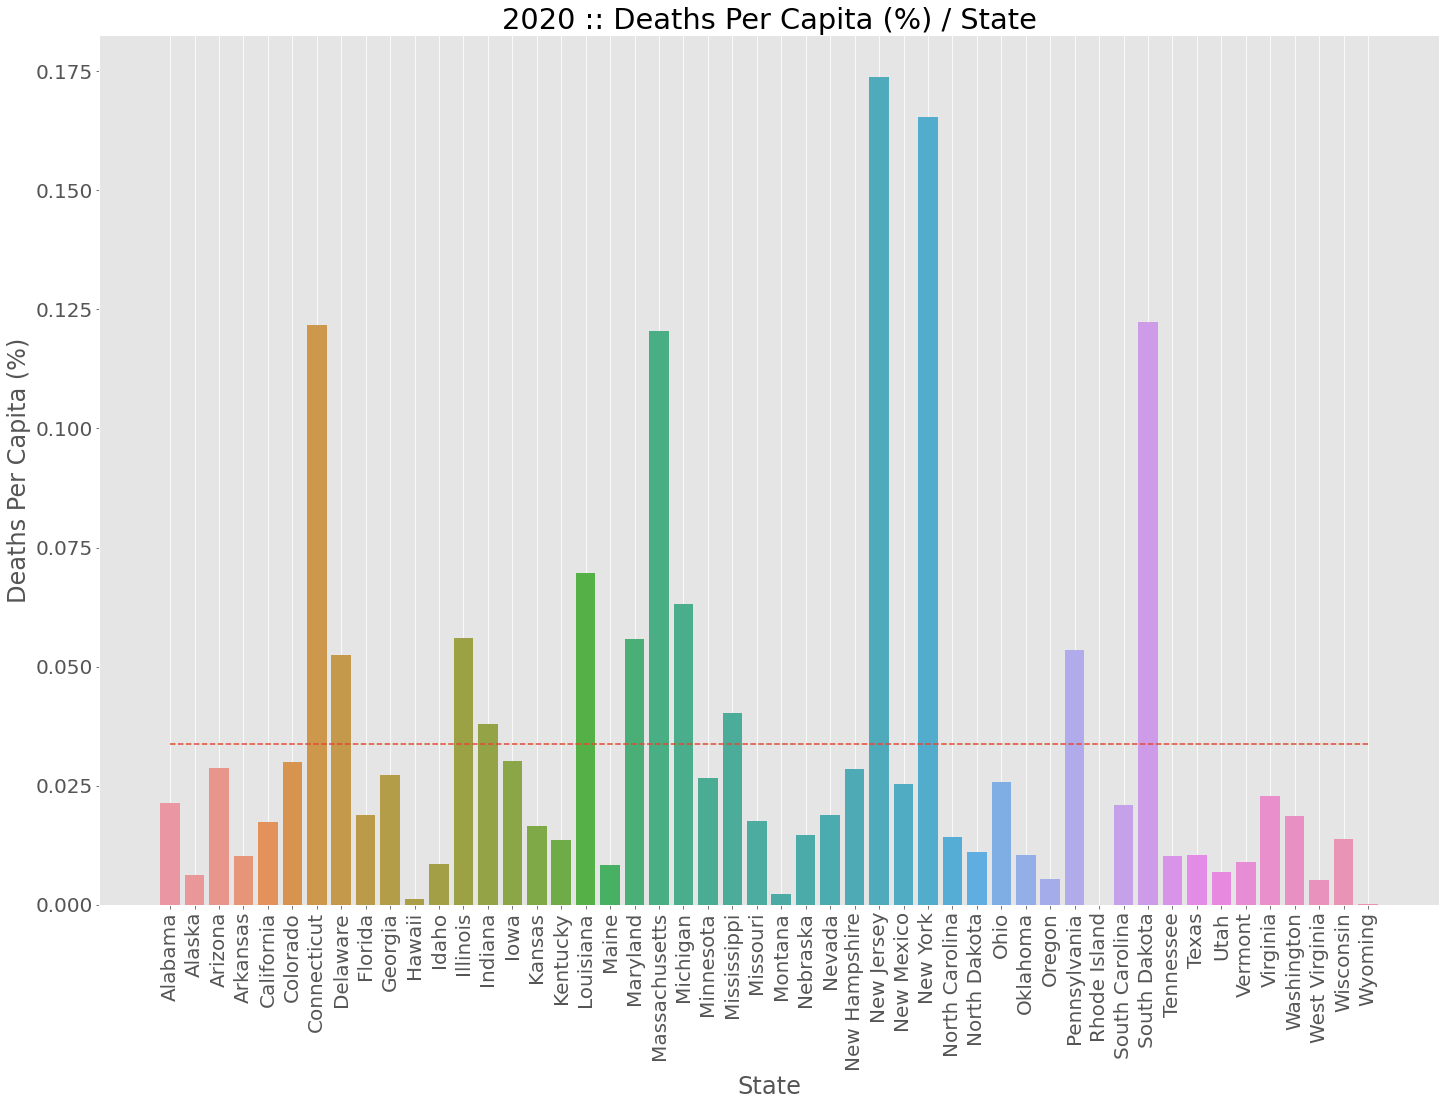

In [8]:
plt.figure(figsize=(24,16))

mean_deaths_per_capita = merged_df["Deaths Per Capita (%)"].mean()
print (f"National average of deaths per capita: {mean_deaths_per_capita}.")

# Creating the plot using Matplotlib's pyplot methods
sns.barplot(x=merged_df["Province_State"], y=merged_df["Deaths Per Capita (%)"])
plt.title("2020 :: Deaths Per Capita (%) / State")
plt.xlabel("State")
plt.ylabel("Deaths Per Capita (%)")
plt.xticks(rotation="vertical")
plt.grid()
plt.plot(merged_df["Province_State"], pd.Series(mean_deaths_per_capita, index=range(len(merged_df))),linestyle="--")
plt.savefig(fname="./images/2020 - Deaths Per Capita.png")

## Plot 1 - Analysis
* This plot brings the impact and % of deths per capita for each State.
* As an example, in New Jersey, 175 deaths for each 10,000 people.
* More than 100 deths per group of 10k people in Connecticut, Massachusetts, New Jersey, New York and South Dakota
* National average of deaths per capita: 0.0338 %

## Plot 2 - 2020 :: Confirmed Cases Per Capita (%) / State

National average of confirmed cases per capita (%): 0.8218917610128276.


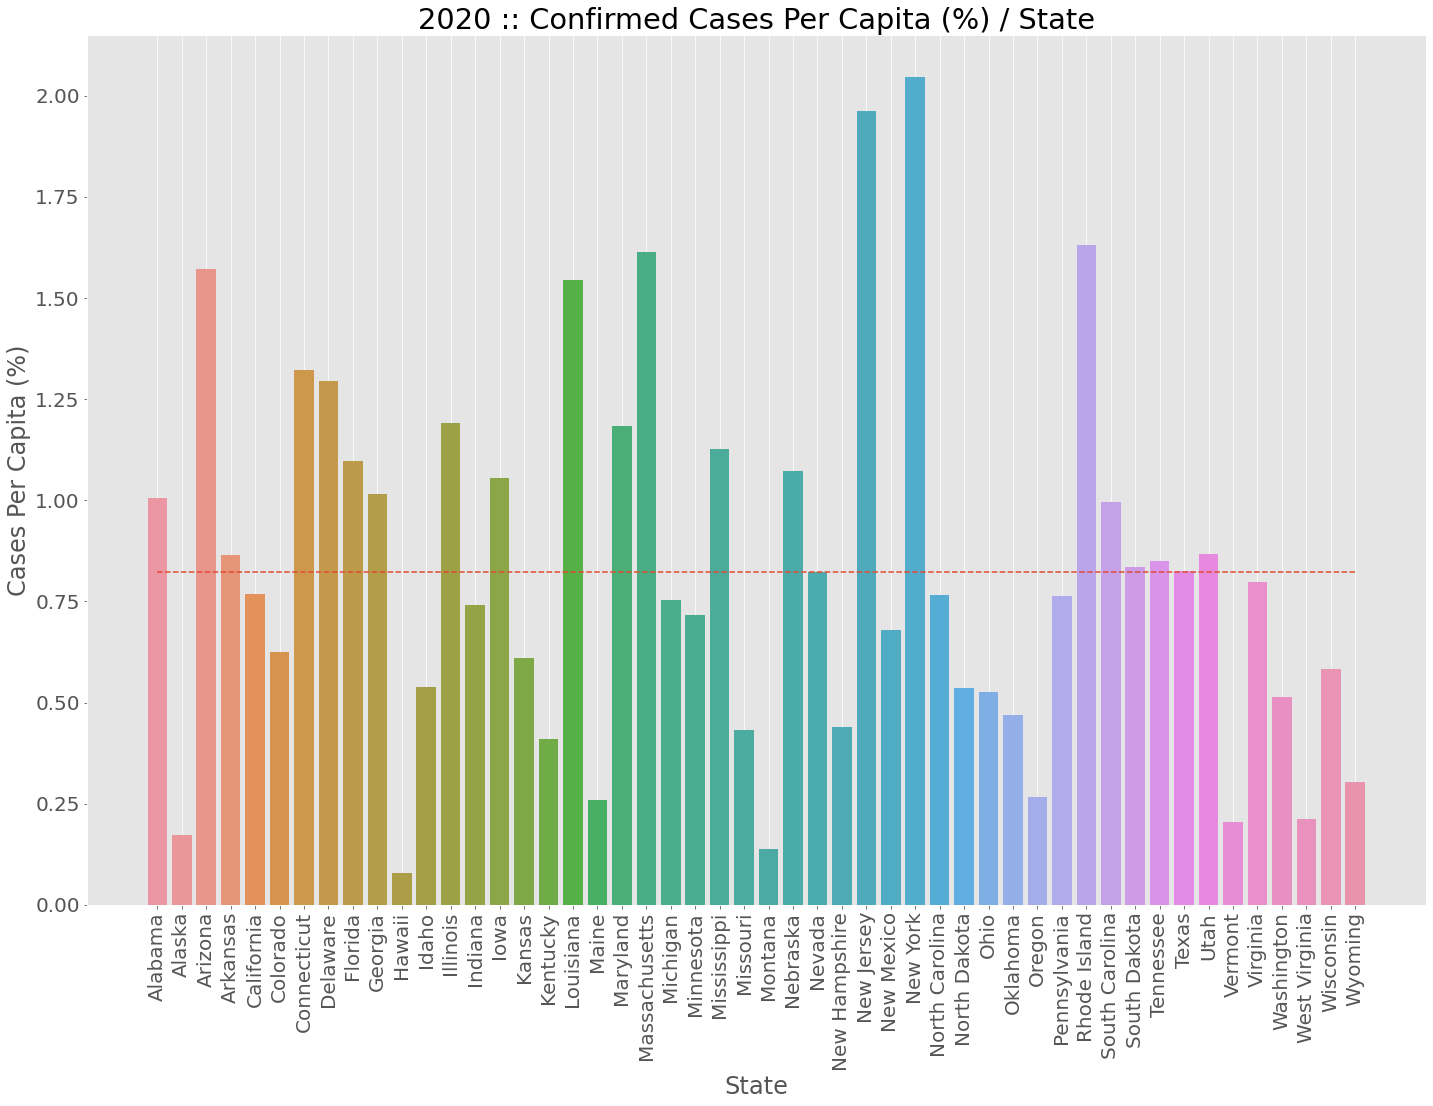

In [9]:
plt.figure(figsize=(24,16))

mean_cases_per_capita = merged_df["Cases Per Capita (%)"].mean()
print (f"National average of confirmed cases per capita (%): {mean_cases_per_capita}.")

# Creating the plot using Matplotlib's pyplot methods
sns.barplot(x=merged_df["Province_State"], y=merged_df["Cases Per Capita (%)"])
plt.title("2020 :: Confirmed Cases Per Capita (%) / State")
plt.xlabel("State")
plt.ylabel("Cases Per Capita (%)")
plt.xticks(rotation="vertical")
plt.grid()
plt.plot(merged_df["Province_State"], pd.Series(mean_cases_per_capita, index=range(len(merged_df))),linestyle="--")
plt.savefig(fname="./images/2020 - Confirmed Cases Per Capita.png")

In [ ]:
Plot 2 - Analysis
This plot brings the impact and % of Per Confirmed Cases for each State.
20% of the states are above of the mean.


## Plot 3 - 2020 :: Deaths Per Confirmed Cases (%) / State

National average of deaths per confirmed cases (%): 3.6763365847382556.


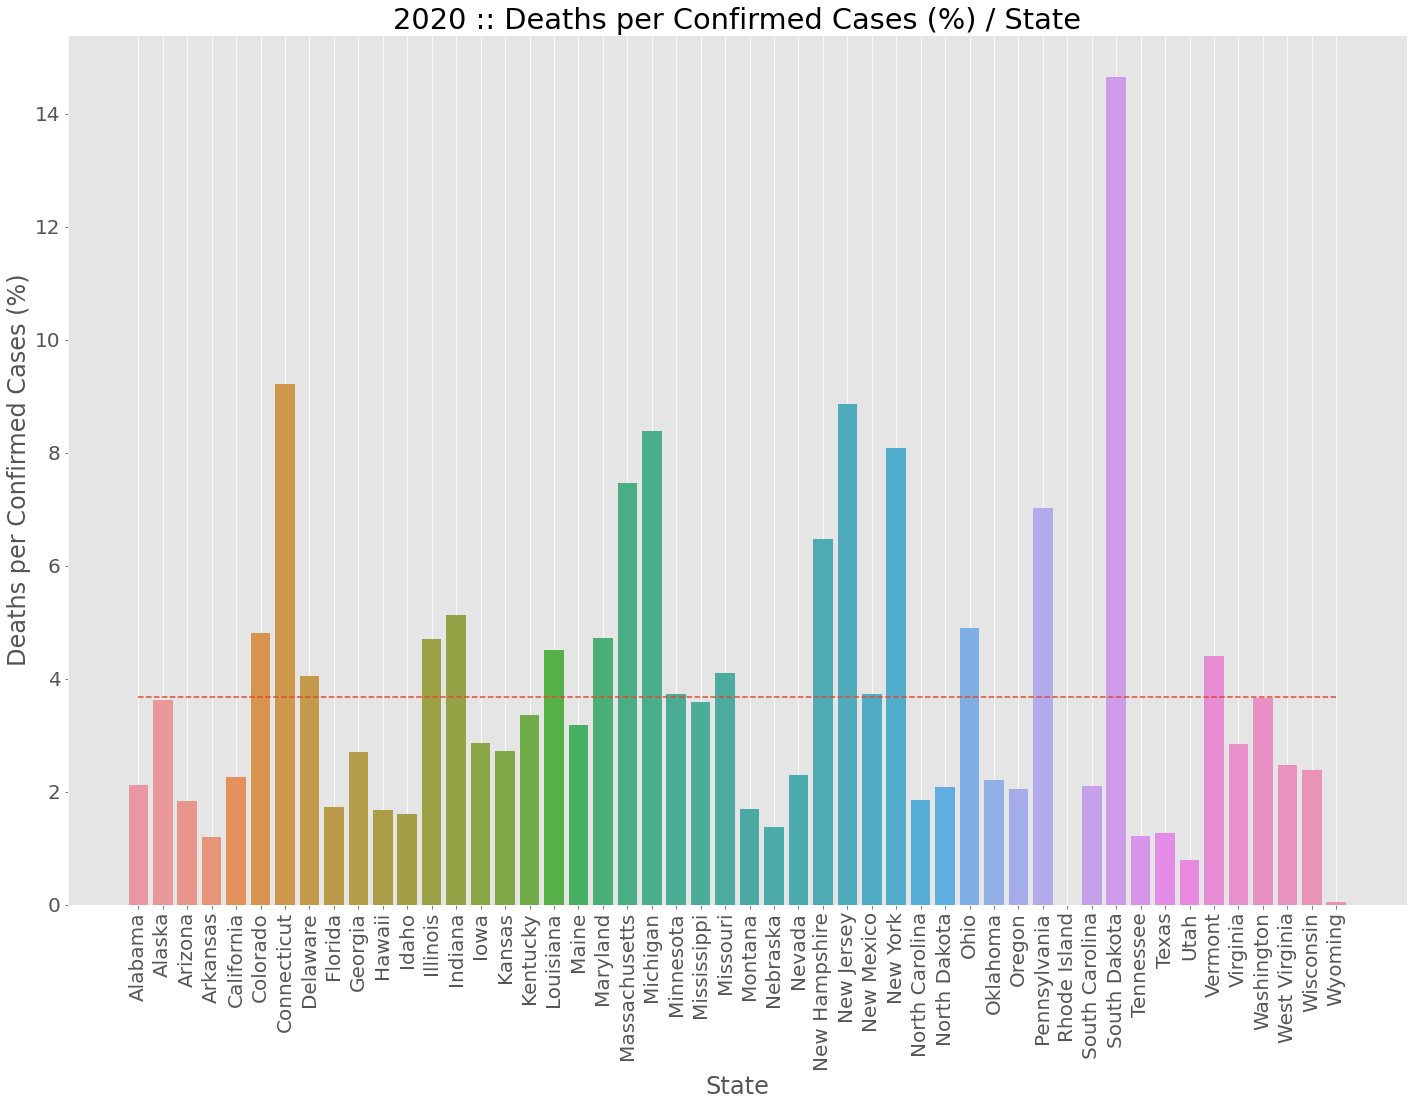

In [10]:
plt.figure(figsize=(24,16))

mean_deaths_per_cases = merged_df["Deaths per Confirmed Cases (%)"].mean()
print (f"National average of deaths per confirmed cases (%): {mean_deaths_per_cases}.")

# Creating the plot using Matplotlib's pyplot methods
sns.barplot(x=merged_df["Province_State"], y=merged_df["Deaths per Confirmed Cases (%)"])
plt.title("2020 :: Deaths per Confirmed Cases (%) / State")
plt.xlabel("State")
plt.ylabel("Deaths per Confirmed Cases (%)")
plt.xticks(rotation="vertical")
plt.grid()
plt.plot(merged_df["Province_State"], pd.Series(mean_deaths_per_cases, index=range(len(merged_df))),linestyle="--")
plt.savefig(fname="./images/2020 - Deaths Per Confirmed Cases.png")

In [11]:
summary_df = merged_df[["Province_State", "Confirmed", "Deaths"]]
summary_df = summary_df.set_index(["Province_State"])
summary_df

,Confirmed,Deaths
Province_State,,
Alabama,49174,1043
Alaska,1268,46
Arizona,112671,2063
Arkansas,26052,311
California,302484,6860
Colorado,35507,1706
Connecticut,47209,4348
Delaware,12531,508
Florida,232718,4018


In [28]:
fig  = summary_df.plot.bar(title="some title")
fig.update_layout(title_x=0.5)
# TO-DO: How to save this interactive file ?
# TO-DO: How to centralise the title ?
# TO-DO: How to rotate the xlabels ?

## Getting data from CSV file - 2021 Oxford Database - USA by state
* Number of Confirmed Cases
* Number of Deaths
* Number of Vaccinated population
* Government Response Index
* Database coverage: 01/01/2021 to 31/12/2021

In [13]:
# Creating the DataFrame from the CSV file - 2021 Oxford Database - USA by state
vaccination_data_master_df = pd.read_csv("./Resources/oxford_data_2021.csv")

C:\Users\giova\AppData\Local\Temp\ipykernel_4480\2016224550.py:2: DtypeWarning:

Columns (82) have mixed types. Specify dtype option on import or set low_memory=False.



In [14]:
# Creating a copy of the DataFrame to start applying the required filters
vaccination_clean_df = vaccination_data_master_df.copy()

# Converting the type of the Date (as of string in the CSF file, format 'YYYYMMDD')
vaccination_clean_df["Date"].astype(int)

# Filtering to brin the data only for the last date of the database (31/12/2021)
vaccination_clean_df = vaccination_clean_df.loc[vaccination_clean_df["Date"] == vaccination_clean_df["Date"].max(),:]

# Removing the unwanted RegionName from the database
vaccination_clean_df = vaccination_clean_df.loc[vaccination_clean_df["RegionName"] != "Washington DC",:]
vaccination_clean_df = vaccination_clean_df.dropna(subset=["RegionName"])

# Considering only the required columns: "RegionName", "Date", "ConfirmedCases", "ConfirmedDeaths", "StringencyIndex_Vaccinated", "GovernmentResponseIndex_Vaccinated_ForDisplay"
# The column 'PopulationVaccinated' brings the percentage of the population of that particular state already vaccinated at the selected date.
vaccination_clean_df = vaccination_clean_df[["RegionName", "Date", "ConfirmedCases", "ConfirmedDeaths", "StringencyIndex_Vaccinated", "GovernmentResponseIndex_Vaccinated_ForDisplay", "PopulationVaccinated"]]
vaccination_clean_df

,RegionName,Date,ConfirmedCases,ConfirmedDeaths,StringencyIndex_Vaccinated,GovernmentResponseIndex_Vaccinated_ForDisplay,PopulationVaccinated
729,Alaska,20211231,157169,978,31.94,41.15,56.33
1094,Alabama,20211231,896614,16455,39.81,46.35,47.63
1459,Arkansas,20211231,566486,9148,15.74,34.90,51.21
1824,Arizona,20211231,1381488,24229,13.89,36.20,57.01
2189,California,20211231,5517870,76478,21.30,45.83,64.22
2554,Colorado,20211231,1001343,10806,20.37,35.16,66.22
2919,Connecticut,20211231,510188,9160,15.74,35.94,74.60
3649,Delaware,20211231,180366,2286,23.15,41.67,64.16
4014,Florida,20211231,4209927,62504,13.89,28.65,63.36
4379,Georgia,20211231,1839879,31443,17.59,32.03,51.08


## Getting data from Census API to get Population data
* Calculating the Population vaccinated based on Census data

In [15]:
# Create a copy of the DataFrame from the CSV file - 2021 Oxford Database - USA by state
vaccination_cleanUSA_df = vaccination_data_master_df.copy()

# Calculating the total population of USA based on the data extracted from Census API
usa_population = census_pd['Population'].sum()

# Converting the DateTime from CSV file to Date time.
vaccination_cleanUSA_df['Date'] = pd.to_datetime(vaccination_cleanUSA_df['Date'], format='%Y%m%d', errors='coerce')
vaccination_cleanUSA_df['Date'] = [d.date() for d in vaccination_cleanUSA_df["Date"]]

# Filtering to get the national information from the database ('RegionName' is empty)
vaccination_cleanUSA_df = vaccination_cleanUSA_df.loc[vaccination_cleanUSA_df["RegionName"].isna(),:]

# Data Frame initialised only with the required columns
vaccination_cleanUSA_df = vaccination_cleanUSA_df[["Date", "ConfirmedCases", "ConfirmedDeaths","PopulationVaccinated"]]

# Calculating new columns of the Data Frame
vaccination_cleanUSA_df["PopulationVaccinated (%)"] = vaccination_cleanUSA_df["PopulationVaccinated"]
vaccination_cleanUSA_df["PopulationVaccinated"] = vaccination_cleanUSA_df["PopulationVaccinated"] / 100 * usa_population
vaccination_cleanUSA_df["PopulationVaccinated"] = vaccination_cleanUSA_df["PopulationVaccinated"].astype(int)

vaccination_cleanUSA_df["Ratio Deaths per Cases (%)"] = vaccination_cleanUSA_df["ConfirmedDeaths"]/vaccination_cleanUSA_df["ConfirmedCases"]
vaccination_cleanUSA_df["Ratio Deaths per Vaccinated (%)"] = vaccination_cleanUSA_df["ConfirmedDeaths"]/vaccination_cleanUSA_df["PopulationVaccinated"]
vaccination_cleanUSA_df["ConfirmedCases (%)"] = vaccination_cleanUSA_df["ConfirmedCases"] / usa_population
vaccination_cleanUSA_df["ConfirmedDeaths (%)"] = vaccination_cleanUSA_df["ConfirmedDeaths"] / usa_population

vaccination_cleanUSA_df

,Date,ConfirmedCases,ConfirmedDeaths,PopulationVaccinated,PopulationVaccinated (%),Ratio Deaths per Cases (%),Ratio Deaths per Vaccinated (%),ConfirmedCases (%),ConfirmedDeaths (%)
0,2021-01-01,20398851,352747,65964,0.02,0.017292,5.347568,0.061848,0.001069
1,2021-01-02,20671292,355267,65964,0.02,0.017186,5.385771,0.062674,0.001077
2,2021-01-03,20874520,356689,65964,0.02,0.017087,5.407328,0.063290,0.001081
3,2021-01-04,21061497,358701,98947,0.03,0.017031,3.625183,0.063857,0.001088
4,2021-01-05,21293660,362273,197894,0.06,0.017013,1.830642,0.064560,0.001098
...,...,...,...,...,...,...,...,...,...
360,2021-12-27,52918601,818730,207393928,62.88,0.015471,0.003948,0.160445,0.002482
361,2021-12-28,53291067,821022,207624806,62.95,0.015406,0.003954,0.161574,0.002489
362,2021-12-29,53802655,823390,207855683,63.02,0.015304,0.003961,0.163125,0.002496
363,2021-12-30,54400342,824880,208086560,63.09,0.015163,0.003964,0.164937,0.002501


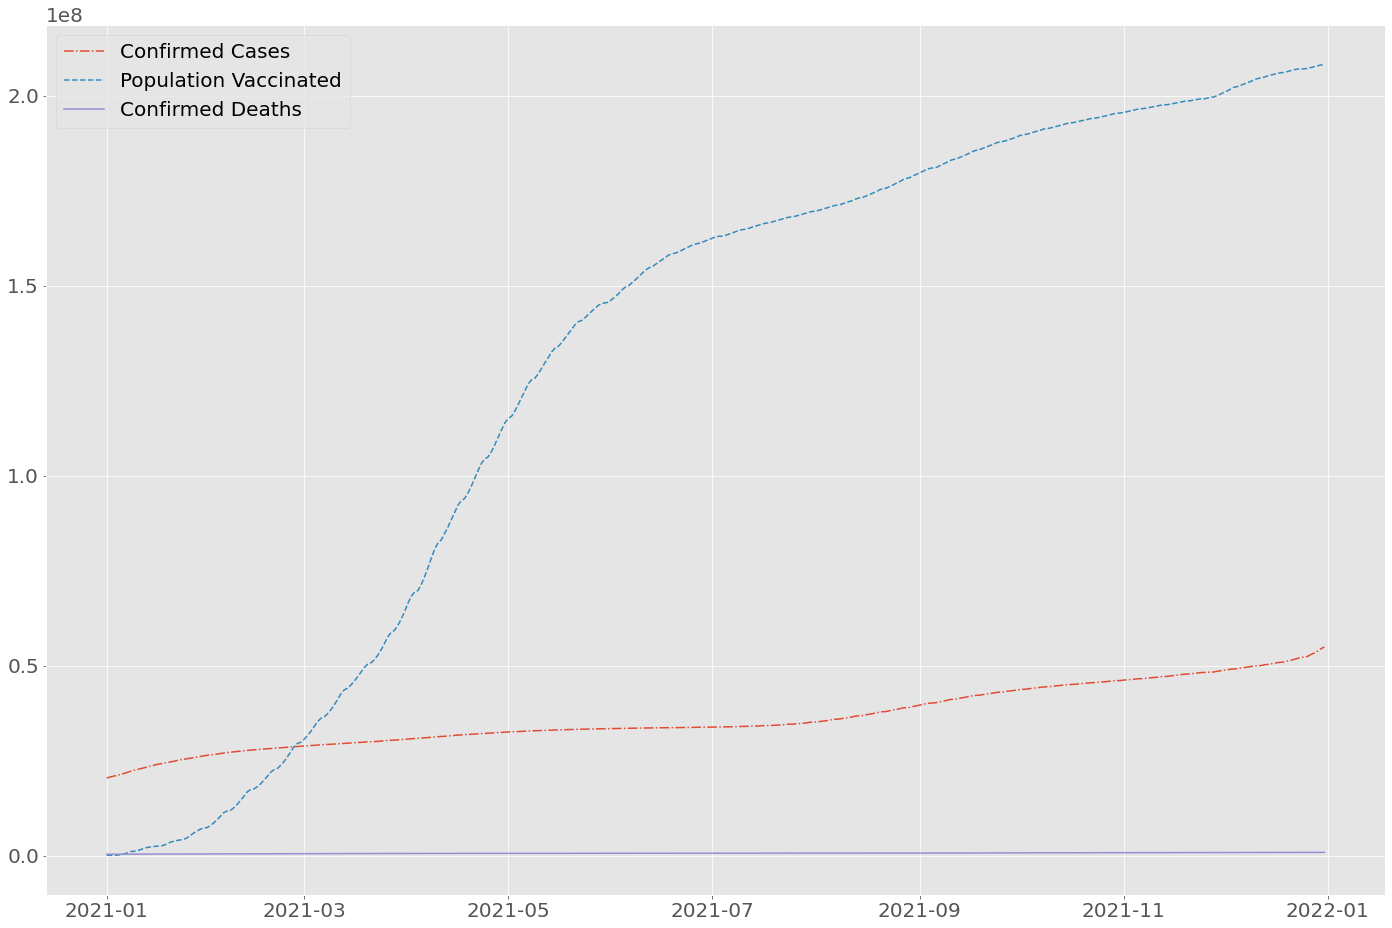

In [16]:
# Plot the progress of Confirmed Cases and the Population being vaccinated over the year of 2021

plt.figure(figsize=(24,16))

plt.plot(vaccination_cleanUSA_df["Date"], vaccination_cleanUSA_df["ConfirmedCases"], label = "Confirmed Cases", linestyle="-.")
plt.plot(vaccination_cleanUSA_df["Date"], vaccination_cleanUSA_df["PopulationVaccinated"],label = "Population Vaccinated", linestyle="--")
plt.plot(vaccination_cleanUSA_df["Date"], vaccination_cleanUSA_df["ConfirmedDeaths"], label = "Confirmed Deaths", linestyle='-')
plt.legend()
plt.savefig(fname="./images/2021 - Deaths and Vaccinated and Confirmed Cases.png")

In [17]:
# Identifying the highest death per confirmed case ratio, and which date it was
highest_death_per_case_ratio = vaccination_cleanUSA_df["Ratio Deaths per Cases (%)"].max()
date_highest_death_per_case_ratio = (vaccination_cleanUSA_df.loc[vaccination_cleanUSA_df["Ratio Deaths per Cases (%)"] == highest_death_per_case_ratio])["Date"]

# Identifying the lowest death per confirmed case ratio, and which date it was
lowest_death_per_case_ratio = vaccination_cleanUSA_df["Ratio Deaths per Cases (%)"].min()
date_lowest_death_per_case_ratio = (vaccination_cleanUSA_df.loc[vaccination_cleanUSA_df["Ratio Deaths per Cases (%)"] == lowest_death_per_case_ratio])["Date"]

# Printing the information for further analysis
print(f"Date with the highest deaths per cases ratio: ({highest_death_per_case_ratio}) - {date_highest_death_per_case_ratio}")
print(f"Date with the lowest deaths per cases ratio: ({lowest_death_per_case_ratio}) - {date_lowest_death_per_case_ratio}")
print(f"Impact of deaths per cases after vaccination started (2021): {(1-(lowest_death_per_case_ratio/highest_death_per_case_ratio))*100} %")

# Plottin the Data Frame
vaccination_cleanUSA_df.plot(x='Date', y=['Ratio Deaths per Cases (%)'], title="2021 :: Deaths per Confirmed Cases Ratio (%)")
# TO-DO: How to save this interactive file ?
# TO-DO: How to centralise the title ?
# TO-DO: How to rotate the xlabels ?

Date with the highest deaths per cases ratio: (0.018013734418754743) - 76    2021-03-18
Name: Date, dtype: object
Date with the lowest deaths per cases ratio: (0.01503509293144667) - 364    2021-12-31
Name: Date, dtype: object
Impact of deaths per cases after vaccination started (2021): 16.535391374522 %


In [18]:
vaccination_cleanUSA_df.plot(x='Date', y=['Ratio Deaths per Vaccinated (%)'], title="2021 :: Deaths per Vaccinated Population Ratio (%)")

## Getting data from CSV file - 2020 Oxford Database - USA by state
* Number of Confirmed Cases
* Number of Deaths
* Number of Vaccinated population = 0 (no vaccination in 2020)
* Government Response Index
* Database coverage: 01/01/2020 to 31/12/2020

In [19]:
# Creating the DataFrame from the CSV file - 2020 Oxford Database - USA by state
oxford_data_master_2020_df = pd.read_csv("./Resources/oxford_data_2020.csv")

# Create a copy of the DataFrame from the CSV file - 2021 Oxford Database - USA by state
oxford_data_master_2021_df = vaccination_data_master_df.copy()

# Data Frame initialised only with the required columns
oxford_data_master_2020_df = oxford_data_master_2020_df[["RegionName", "Date", "ConfirmedCases", "ConfirmedDeaths","PopulationVaccinated"]]
oxford_data_master_2021_df = oxford_data_master_2021_df[["RegionName", "Date", "ConfirmedCases", "ConfirmedDeaths","PopulationVaccinated"]]

# Concatenating dataframes (2020 and 2021)
oxford_data_master_2020_2021_df = pd.concat([oxford_data_master_2020_df, oxford_data_master_2021_df])

# Filtering to get the national information from the database ('RegionName' is empty)
oxford_data_master_2020_2021_df = oxford_data_master_2020_2021_df.loc[oxford_data_master_2020_2021_df["RegionName"].isna(),:]

# Data Frame initialised only with the required columns
oxford_data_master_2020_2021_df = oxford_data_master_2020_2021_df.reset_index()
oxford_data_master_2020_2021_df = oxford_data_master_2020_2021_df[["Date", "ConfirmedCases", "ConfirmedDeaths","PopulationVaccinated"]]

# Updating NaN fields with 0 (zero)
oxford_data_master_2020_2021_df = oxford_data_master_2020_2021_df.fillna(0)

# Converting the DateTime from CSV file to Date time.
oxford_data_master_2020_2021_df['Date'] = pd.to_datetime(oxford_data_master_2020_2021_df['Date'], format='%Y%m%d', errors='coerce')
oxford_data_master_2020_2021_df['Date'] = [d.date() for d in oxford_data_master_2020_2021_df["Date"]]
oxford_data_master_2020_2021_df

# Calculating new columns of the Data Frame
oxford_data_master_2020_2021_df["PopulationVaccinated (%)"] = oxford_data_master_2020_2021_df["PopulationVaccinated"]
oxford_data_master_2020_2021_df["PopulationVaccinated"] = oxford_data_master_2020_2021_df["PopulationVaccinated"] / 100 * usa_population
oxford_data_master_2020_2021_df["PopulationVaccinated"] = oxford_data_master_2020_2021_df["PopulationVaccinated"].astype(int)

oxford_data_master_2020_2021_df["Ratio Deaths per Cases (%)"] = oxford_data_master_2020_2021_df["ConfirmedDeaths"] / oxford_data_master_2020_2021_df["ConfirmedCases"]
oxford_data_master_2020_2021_df["Ratio Deaths per Vaccinated (%)"] = oxford_data_master_2020_2021_df["ConfirmedDeaths"] / oxford_data_master_2020_2021_df["PopulationVaccinated"]
oxford_data_master_2020_2021_df["ConfirmedCases (%)"] = oxford_data_master_2020_2021_df["ConfirmedCases"] / usa_population
oxford_data_master_2020_2021_df["ConfirmedDeaths (%)"] = oxford_data_master_2020_2021_df["ConfirmedDeaths"] / usa_population

oxford_data_master_2020_2021_df

C:\Users\giova\AppData\Local\Temp\ipykernel_4480\2019381489.py:2: DtypeWarning:

Columns (82,93,121,122,130) have mixed types. Specify dtype option on import or set low_memory=False.



,Date,ConfirmedCases,ConfirmedDeaths,PopulationVaccinated,PopulationVaccinated (%),Ratio Deaths per Cases (%),Ratio Deaths per Vaccinated (%),ConfirmedCases (%),ConfirmedDeaths (%)
0,2020-01-01,0.0,0.0,0,0.00,NaN,NaN,0.000000,0.000000
1,2020-01-02,0.0,0.0,0,0.00,NaN,NaN,0.000000,0.000000
2,2020-01-03,0.0,0.0,0,0.00,NaN,NaN,0.000000,0.000000
3,2020-01-04,0.0,0.0,0,0.00,NaN,NaN,0.000000,0.000000
4,2020-01-05,0.0,0.0,0,0.00,NaN,NaN,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
726,2021-12-27,52918601.0,818730.0,207393928,62.88,0.015471,0.003948,0.160445,0.002482
727,2021-12-28,53291067.0,821022.0,207624806,62.95,0.015406,0.003954,0.161574,0.002489
728,2021-12-29,53802655.0,823390.0,207855683,63.02,0.015304,0.003961,0.163125,0.002496
729,2021-12-30,54400342.0,824880.0,208086560,63.09,0.015163,0.003964,0.164937,0.002501


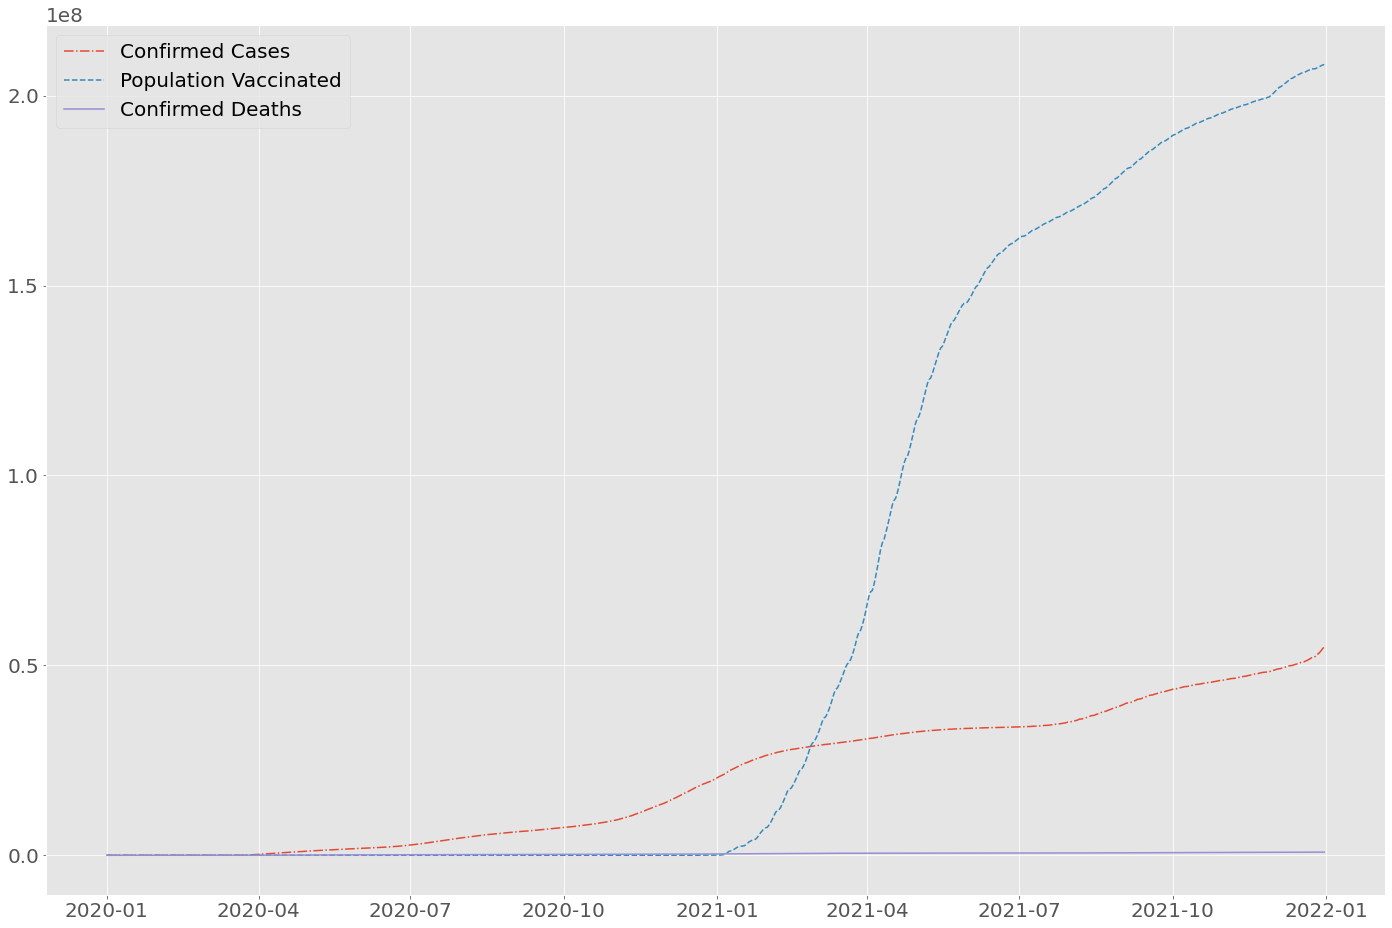

In [20]:
# Plot the progress of Confirmed Cases and the Population being vaccinated over the year of 2020 and 2021

plt.figure(figsize=(24,16))

plt.plot(oxford_data_master_2020_2021_df["Date"], oxford_data_master_2020_2021_df["ConfirmedCases"], label = "Confirmed Cases", linestyle="-.")
plt.plot(oxford_data_master_2020_2021_df["Date"], oxford_data_master_2020_2021_df["PopulationVaccinated"],label = "Population Vaccinated", linestyle="--")
plt.plot(oxford_data_master_2020_2021_df["Date"], oxford_data_master_2020_2021_df["ConfirmedDeaths"], label = "Confirmed Deaths", linestyle='-')
plt.legend()
plt.savefig(fname="./images/2020 to 2021 - Deaths and Vaccinated and Confirmed Cases.png")

## Geopandas

In [21]:
import geopandas as gpd

ModuleNotFoundError: No module named 'geopandas'

In [22]:
# Identifying the highest death per confirmed case ratio, and which date it was
highest_death_per_case_ratio1 = oxford_data_master_2020_2021_df["Ratio Deaths per Cases (%)"].max()
date_highest_death_per_case_ratio1 = (oxford_data_master_2020_2021_df.loc[oxford_data_master_2020_2021_df["Ratio Deaths per Cases (%)"] == highest_death_per_case_ratio])["Date"]

# Identifying the lowest death per confirmed case ratio, and which date it was
lowest_death_per_case_ratio1 = oxford_data_master_2020_2021_df["Ratio Deaths per Cases (%)"].min()
date_lowest_death_per_case_ratio1 = (oxford_data_master_2020_2021_df.loc[oxford_data_master_2020_2021_df["Ratio Deaths per Cases (%)"] == lowest_death_per_case_ratio])["Date"]

# Printing the information for further analysis
print(f"Date with the highest deaths per cases ratio: ({highest_death_per_case_ratio1}) - {date_highest_death_per_case_ratio1}")
print(f"Date with the lowest deaths per cases ratio: ({lowest_death_per_case_ratio1}) - {date_lowest_death_per_case_ratio1}")
print(f"Impact of deaths per cases after vaccination started (2021): {(1-(lowest_death_per_case_ratio1/highest_death_per_case_ratio1))*100} %")

# Plottin the Data Frame
oxford_data_master_2020_2021_df.plot(x='Date', y=['Ratio Deaths per Cases (%)'], title="2021 :: Deaths per Confirmed Cases Ratio (%)")
# TO-DO: How to save this interactive file ?
# TO-DO: How to centralise the title ?
# TO-DO: How to rotate the xlabels ?

Date with the highest deaths per cases ratio: (0.10909090909090909) - 442    2021-03-18
Name: Date, dtype: object
Date with the lowest deaths per cases ratio: (0.0) - 730    2021-12-31
Name: Date, dtype: object
Impact of deaths per cases after vaccination started (2021): 100.0 %


# Government Response

In [23]:
# Creating the DataFrame from the CSV file - 2020 Oxford Database - USA by state
oxford_data_master_2020_df = pd.read_csv("./Resources/oxford_data_2020.csv")

# Create a copy of the DataFrame from the CSV file - 2021 Oxford Database - USA by state
oxford_data_master_2021_df = vaccination_data_master_df.copy()

# Data Frame initialised only with the required columns
oxford_data_master_2020_df = oxford_data_master_2020_df[["RegionName", "Date", "ConfirmedCases", "ConfirmedDeaths","PopulationVaccinated", "GovernmentResponseIndex_Vaccinated_ForDisplay"]]
oxford_data_master_2021_df = oxford_data_master_2021_df[["RegionName", "Date", "ConfirmedCases", "ConfirmedDeaths","PopulationVaccinated", "GovernmentResponseIndex_Vaccinated_ForDisplay"]]

# Concatenating dataframes (2020 and 2021)
oxford_data_master_2020_2021_df = pd.concat([oxford_data_master_2020_df, oxford_data_master_2021_df])

# Filtering to get the national information from the database ('RegionName' is empty)
oxford_data_master_2020_2021_df = oxford_data_master_2020_2021_df.loc[oxford_data_master_2020_2021_df["RegionName"].isna(),:]

# Data Frame initialised only with the required columns
oxford_data_master_2020_2021_df = oxford_data_master_2020_2021_df.reset_index()
oxford_data_master_2020_2021_df = oxford_data_master_2020_2021_df[["Date", "ConfirmedCases", "ConfirmedDeaths","PopulationVaccinated", "GovernmentResponseIndex_Vaccinated_ForDisplay"]]

# Updating NaN fields with 0 (zero)
oxford_data_master_2020_2021_df = oxford_data_master_2020_2021_df.fillna(0)

# Converting the DateTime from CSV file to Date time.
oxford_data_master_2020_2021_df['Date'] = pd.to_datetime(oxford_data_master_2020_2021_df['Date'], format='%Y%m%d', errors='coerce')
oxford_data_master_2020_2021_df['Date'] = [d.date() for d in oxford_data_master_2020_2021_df["Date"]]
oxford_data_master_2020_2021_df

# Calculating new columns of the Data Frame
oxford_data_master_2020_2021_df["Deaths per 1k confirmed cases"] = oxford_data_master_2020_2021_df["ConfirmedDeaths"]/oxford_data_master_2020_2021_df["ConfirmedCases"]*1000

oxford_data_master_2020_2021_df

C:\Users\giova\AppData\Local\Temp\ipykernel_4480\1074253912.py:2: DtypeWarning:

Columns (82,93,121,122,130) have mixed types. Specify dtype option on import or set low_memory=False.



,Date,ConfirmedCases,ConfirmedDeaths,PopulationVaccinated,GovernmentResponseIndex_Vaccinated_ForDisplay,Deaths per 1k confirmed cases
0,2020-01-01,0.0,0.0,0.00,0.00,NaN
1,2020-01-02,0.0,0.0,0.00,0.00,NaN
2,2020-01-03,0.0,0.0,0.00,0.00,NaN
3,2020-01-04,0.0,0.0,0.00,0.00,NaN
4,2020-01-05,0.0,0.0,0.00,0.00,NaN
...,...,...,...,...,...,...
726,2021-12-27,52918601.0,818730.0,62.88,25.52,15.471497
727,2021-12-28,53291067.0,821022.0,62.95,25.52,15.406372
728,2021-12-29,53802655.0,823390.0,63.02,25.52,15.303892
729,2021-12-30,54400342.0,824880.0,63.09,25.52,15.163140


In [ ]:
plt.figure(figsize=(24,16))

plt.plot(oxford_data_master_2020_2021_df["Date"], oxford_data_master_2020_2021_df["GovernmentResponseIndex_Vaccinated_ForDisplay"], label = "Government Response", linestyle="-.")
plt.plot(oxford_data_master_2020_2021_df["Date"], oxford_data_master_2020_2021_df["Deaths per 1k confirmed cases"], label = "Deaths per 1k confirmed cases", linestyle='-')
plt.plot(oxford_data_master_2020_2021_df["Date"], oxford_data_master_2020_2021_df["PopulationVaccinated"], label = "Population Vaccinated", linestyle='-')
plt.legend()
plt.savefig(fname="./images/2020 to 2021 - Government Response.png")